<a href="https://colab.research.google.com/github/thieshanthan/CompressiveDabbaMu/blob/main/b_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import Dataset, SubsetRandomSampler


cudnn.benchmark = True
plt.ion()


In [2]:
tl_class_dict = {
 0: "Major Brick",
 1: "Major Timber",
 2: "Major Steel sheet",
 3: "Major Plastered and painted",
 4: "Major Concrete and glass",
 5: "Major Glass",
 6: "Major Fiber cement sheet",
 7: "Major Concrete panels",
 8: "Other"
}
tl_class_inv_map = {v:k for k,v in tl_class_dict.items()}

In [3]:
class GBuildingDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, split_ratio=0.8, transform=None):
        self.root_dir = root_dir
        self.split_ratio = split_ratio
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = tl_class_inv_map
        self.data = self._load_data()
        self._split_data()

    def _load_data(self):
        data = []
        for cls_name in self.classes:
            cls_path = os.path.join(self.root_dir, cls_name)
            if not os.path.isdir(cls_path):
                continue

            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                data.append((img_path, self.class_to_idx[cls_name]))

        return data

    def _split_data(self):
        dataset_size = len(self.data)
        split_idx = int(dataset_size * self.split_ratio)
        indices = list(range(dataset_size))
        # Shuffle the indices before splitting
        torch.manual_seed(42)  # For reproducibility
        shuffled_indices = torch.randperm(dataset_size)

        self.train_indices = shuffled_indices[:split_idx]
        self.val_indices = shuffled_indices[split_idx:]


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_train_sampler(self):
        return SubsetRandomSampler(self.train_indices)

    def get_val_sampler(self):
        return SubsetRandomSampler(self.val_indices)



In [4]:
tl_dataset = GBuildingDataset("/content/drive/MyDrive/Thishanthan/Trans learning")

In [5]:
tl_dataset.get_train_sampler().__len__()

2650

In [6]:
tl_dataset.get_val_sampler().__len__()

663

In [26]:
BATCH_SIZE=64

In [27]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

tl_dataset = GBuildingDataset("/content/drive/MyDrive/Thishanthan/Trans learning",
                              split_ratio=0.8, transform=data_transforms)

dataloaders = {'train': torch.utils.data.DataLoader(tl_dataset, batch_size=BATCH_SIZE,
                                              num_workers=2,
                                             sampler=tl_dataset.get_train_sampler()),
              'val': torch.utils.data.DataLoader(tl_dataset, batch_size=BATCH_SIZE,
                                              num_workers=2,
                                             sampler=tl_dataset.get_val_sampler())}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

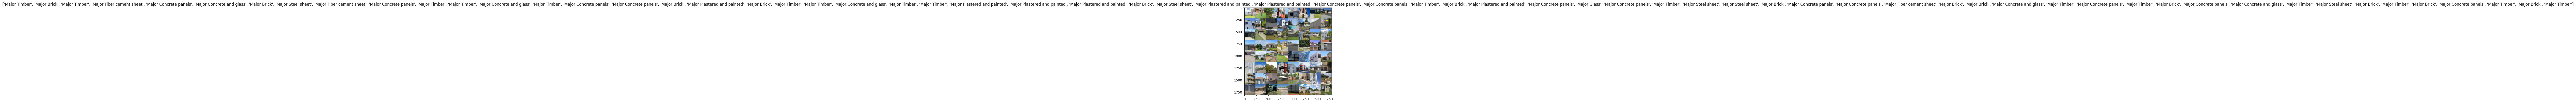

In [28]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [29]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                    epoch_loss = running_loss / tl_dataset.get_train_sampler().__len__()
                    epoch_acc = running_corrects.double() / tl_dataset.get_train_sampler().__len__()

                if phase == 'val':
                    epoch_loss = running_loss / tl_dataset.get_val_sampler().__len__()
                    epoch_acc = running_corrects.double() / tl_dataset.get_val_sampler().__len__()

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [30]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {tl_class_dict[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [31]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(tl_class_dict))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


In [ ]:
visualize_model(model_ft)

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(tl_class_dict))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()